In [10]:
import csv
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from qucumber.nn_states import DensityMatrix
from qucumber.nn_states import ComplexWaveFunction
from qucumber.callbacks import MetricEvaluator
import qucumber.utils.unitaries as unitaries
import qucumber.utils.training_statistics as ts
import qucumber.utils.cplx as cplx
import qucumber.utils.data as data
from qucumber.observables import ObservableBase, to_pm1
from qucumber.observables.pauli import flip_spin
import qucumber

from qulacs.gate import Pauli

In [69]:
# load_model
nn_state_dm_depolarizing = DensityMatrix.autoload("./model_n_pattern_shot=1000_depolarizing.pt", gpu=True)
nn_state_dm_unitary = DensityMatrix.autoload("./model_n_pattern_shot=1000_unitary.pt", gpu=True)
nn_state_dm_depolarizing_unitary = DensityMatrix.autoload("./model_n_pattern_shot=1000_depolarizing_unitary.pt", gpu=True)

def get_density_matrix(nn_state):
    space = nn_state.generate_hilbert_space()
    Z = nn_state.normalization(space)
    tensor = nn_state.rho(space, space)/Z
    matrix = cplx.numpy(tensor)
    return matrix

def get_max_eigvec(matrix):
    e_val, e_vec = np.linalg.eigh(matrix)
    me_val = e_val[-1]
    me_vec = e_vec[:,-1]
    return me_vec

def observable_XX():
    target_list = [0, 1]
    pauli_index = [1, 1] # 1:X , 2:Y, 3:Z
    gate = Pauli(target_list, pauli_index) # = X_1 X_2
    return gate.get_matrix()

rho_noisy_depolarizing = get_density_matrix(nn_state_dm_depolarizing)
max_eigen_vec_depolarizing = get_max_eigvec(rho_noisy_depolarizing)
mev_ev_depolarizing = (np.conjugate(max_eigen_vec_depolarizing).T @ observable_XX() @ max_eigen_vec_depolarizing).real

rho_noisy_unitary = get_density_matrix(nn_state_dm_unitary)
max_eigen_vec_unitary = get_max_eigvec(rho_noisy_unitary)
mev_ev_unitary = (np.conjugate(max_eigen_vec_unitary).T @ observable_XX() @ max_eigen_vec_unitary).real

rho_noisy_depolarizing_unitary = get_density_matrix(nn_state_dm_depolarizing_unitary)
max_eigen_vec_depolarizing_unitary = get_max_eigvec(rho_noisy_depolarizing_unitary)
mev_ev_depolarizing_unitary = (np.conjugate(max_eigen_vec_depolarizing_unitary).T @ observable_XX() @ max_eigen_vec_depolarizing_unitary).real

## varying n_copy

In [11]:
# depolarizing
ev_100_sampiling_depolarizing_df = pd.read_csv("./depolarizing/ev_n_sampling=100.csv")
ev_1000_sampiling_depolarizing_df = pd.read_csv("./depolarizing/ev_n_sampling=1000.csv")
ev_10000_sampiling_depolarizing_df = pd.read_csv("./depolarizing/ev_n_sampling=10000.csv")
ev_100000_sampiling_depolarizing_df = pd.read_csv("./depolarizing/ev_n_sampling=100000.csv")
ev_1000000_sampiling_depolarizing_df = pd.read_csv("./depolarizing/ev_n_sampling=1000000.csv")

# unitary
ev_100_sampiling_unitary_df = pd.read_csv("./unitary/ev_n_sampling=100.csv")
ev_1000_sampiling_unitary_df = pd.read_csv("./unitary/ev_n_sampling=1000.csv")
ev_10000_sampiling_unitary_df = pd.read_csv("./unitary/ev_n_sampling=10000.csv")
ev_100000_sampiling_unitary_df = pd.read_csv("./unitary/ev_n_sampling=100000.csv")
ev_1000000_sampiling_unitary_df = pd.read_csv("./unitary/ev_n_sampling=1000000.csv")

# depolarizing&unitary
ev_100_sampiling_depolarizing_unitary_df = pd.read_csv("./depolarizing&unitary/ev_n_sampling=100.csv")
ev_1000_sampiling_depolarizing_unitary_df = pd.read_csv("./depolarizing&unitary/ev_n_sampling=1000.csv")
ev_10000_sampiling_depolarizing_unitary_df = pd.read_csv("./depolarizing&unitary/ev_n_sampling=10000.csv")
ev_100000_sampiling_depolarizing_unitary_df = pd.read_csv("./depolarizing&unitary/ev_n_sampling=100000.csv")
ev_1000000_sampiling_depolarizing_unitary_df = pd.read_csv("./depolarizing&unitary/ev_n_sampling=1000000.csv")

### n_sample = 100

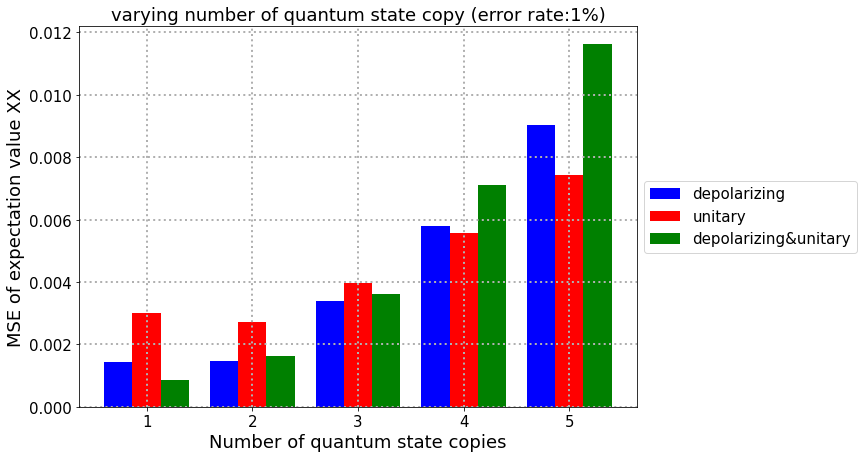

In [81]:
x = np.arange(1, 6)
tick_label = np.arange(1, 6).astype("str")
labels = ["depolarizing", "unitary", "depolarizing&unitary"]

mae_depolarizing_list = []
mae_unitary_list = []
mae_depolarizing_unitary_list = []

var_depolarizing_list = []
var_unitary_list = []
var_depolarizing_unitary_list = []

for col in ev_1000_sampiling_depolarizing_df.columns[::-1]:
    mae_depolarizing_list.append(np.mean(np.square(1-ev_100_sampiling_depolarizing_df[col].values)))
    mae_unitary_list.append(np.mean(np.square(1-ev_100_sampiling_unitary_df[col].values)))
    mae_depolarizing_unitary_list.append(np.mean(np.square(1-ev_100_sampiling_depolarizing_unitary_df[col].values)))
    
    var_depolarizing_list.append(np.var(ev_100_sampiling_depolarizing_df[col].values))
    var_unitary_list.append(np.var(ev_100_sampiling_unitary_df[col].values))
    var_depolarizing_unitary_list.append(np.var(ev_100_sampiling_depolarizing_unitary_df[col].values))

mae_data = [mae_depolarizing_list, mae_unitary_list, mae_depolarizing_unitary_list]
var_data = [var_depolarizing_list, var_unitary_list, var_depolarizing_unitary_list]

margin = 0.2
totoal_width = 1 - margin
color_list = ["blue", "red", "green"]
plt.figure(figsize=(10, 7))

for i, (h, label, c) in enumerate(zip(mae_data, labels, color_list)):
    pos = x - totoal_width *( 1- (2*i+1)/len(mae_data) )/2
    plt.bar(pos, h, width = totoal_width/len(mae_data), label=label, tick_label=tick_label, align="center", color=c)

plt.title('varying number of quantum state copy (error rate:1%)', fontsize=18)
plt.xlabel('Number of quantum state copies', fontsize=18)
plt.ylabel('MSE of expectation value X$\otimes$X', fontsize=18)
plt.xticks(x, tick_label)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)

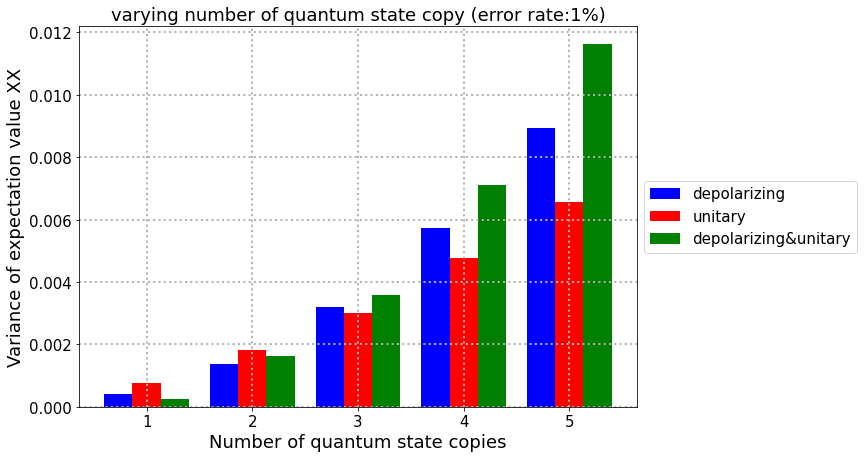

In [44]:
margin = 0.2
totoal_width = 1 - margin
color_list = ["blue", "red", "green"]
plt.figure(figsize=(10, 7))

for i, (h, label, c) in enumerate(zip(var_data, labels, color_list)):
    pos = x - totoal_width *( 1- (2*i+1)/len(var_data) )/2
    plt.bar(pos, h, width = totoal_width/len(var_data), label=label, tick_label=tick_label, align="center", color=c)

plt.title('varying number of quantum state copy (error rate:1%)', fontsize=18)
plt.xlabel('Number of quantum state copies', fontsize=18)
plt.ylabel('Variance of expectation value X$\otimes$X', fontsize=18)
plt.xticks(x, tick_label)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)

### n_sample = 1000

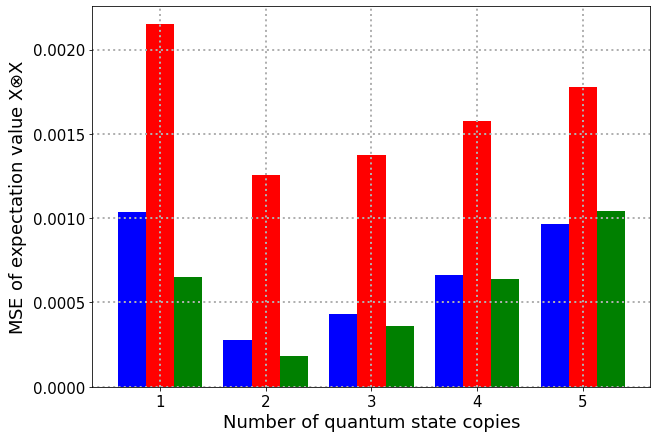

In [111]:
x = np.arange(1, 6)
tick_label = np.arange(1, 6).astype("str")
labels = ["depolarizing", "unitary", "depolarizing&unitary"]

mae_depolarizing_list = []
mae_unitary_list = []
mae_depolarizing_unitary_list = []

var_depolarizing_list = []
var_unitary_list = []
var_depolarizing_unitary_list = []

for col in ev_1000_sampiling_depolarizing_df.columns[::-1]:
    mae_depolarizing_list.append(np.mean(np.square(1-ev_1000_sampiling_depolarizing_df[col].values)))
    mae_unitary_list.append(np.mean(np.square(1-ev_1000_sampiling_unitary_df[col].values)))
    mae_depolarizing_unitary_list.append(np.mean(np.square(1-ev_1000_sampiling_depolarizing_unitary_df[col].values)))
    
    var_depolarizing_list.append(np.var(ev_100_sampiling_depolarizing_df[col].values))
    var_unitary_list.append(np.var(ev_100_sampiling_unitary_df[col].values))
    var_depolarizing_unitary_list.append(np.var(ev_100_sampiling_depolarizing_unitary_df[col].values))

mae_data = [mae_depolarizing_list, mae_unitary_list, mae_depolarizing_unitary_list]
var_data = [var_depolarizing_list, var_unitary_list, var_depolarizing_unitary_list]

margin = 0.2
totoal_width = 1 - margin
color_list = ["blue", "red", "green"]
plt.figure(figsize=(10, 7))

for i, (h, label, c) in enumerate(zip(mae_data, labels, color_list)):
    pos = x - totoal_width *( 1- (2*i+1)/len(mae_data) )/2
    plt.bar(pos, h, width = totoal_width/len(mae_data), label=label, tick_label=tick_label, align="center", color=c)

#plt.title('varying number of quantum state copy (error rate:1%)', fontsize=18)
plt.xlabel('Number of quantum state copies', fontsize=18)
plt.ylabel('MSE of expectation value X$\otimes$X', fontsize=18)
plt.xticks(x, tick_label)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
#plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)
plt.savefig("./figures/varying_n_copy_mse_n_sample=1000.pdf", bbox_inches='tight')

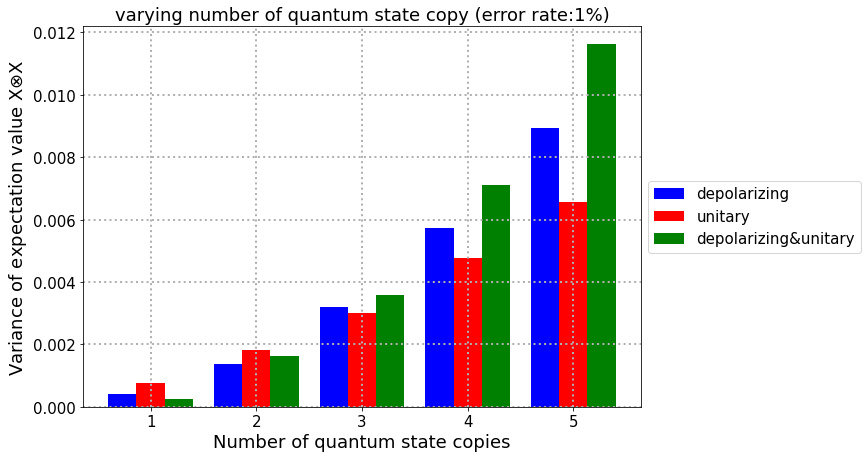

In [101]:
margin = 0.2
totoal_width = 1 - margin
color_list = ["blue", "red", "green"]
plt.figure(figsize=(10, 7))

for i, (h, label, c) in enumerate(zip(var_data, labels, color_list)):
    pos = x - totoal_width *( 1- (2*i+1)/len(var_data) )/2
    plt.bar(pos, h, width = totoal_width/len(var_data), label=label, tick_label=tick_label, align="center", color=c)

plt.title('varying number of quantum state copy (error rate:1%)', fontsize=18)
plt.xlabel('Number of quantum state copies', fontsize=18)
plt.ylabel('Variance of expectation value X$\otimes$X', fontsize=18)
plt.xticks(x, tick_label)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)

### n_sample = 1000000

#### diff max eigen & sampling VD

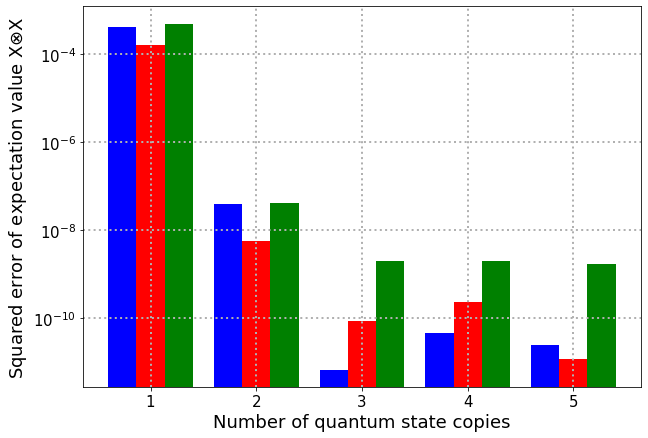

In [106]:
x = np.arange(1, 6)
tick_label = np.arange(1, 6).astype("str")
labels = ["depolarizing", "unitary", "depolarizing&unitary"]

mae_depolarizing_list = []
mae_unitary_list = []
mae_depolarizing_unitary_list = []

var_depolarizing_list = []
var_unitary_list = []
var_depolarizing_unitary_list = []

for col in ev_1000_sampiling_depolarizing_df.columns[::-1]:
    mae_depolarizing_list.append(np.square(mev_ev_depolarizing-np.mean(ev_1000000_sampiling_depolarizing_df[col].values)))
    mae_unitary_list.append(np.square(mev_ev_unitary-np.mean(ev_1000000_sampiling_unitary_df[col].values)))
    mae_depolarizing_unitary_list.append(np.square(mev_ev_depolarizing_unitary-np.mean(ev_1000000_sampiling_depolarizing_unitary_df[col].values)))
    
    var_depolarizing_list.append(np.var(ev_1000000_sampiling_depolarizing_df[col].values))
    var_unitary_list.append(np.var(ev_1000000_sampiling_unitary_df[col].values))
    var_depolarizing_unitary_list.append(np.var(ev_1000000_sampiling_depolarizing_unitary_df[col].values))

mae_data = [mae_depolarizing_list, mae_unitary_list, mae_depolarizing_unitary_list]
var_data = [var_depolarizing_list, var_unitary_list, var_depolarizing_unitary_list]

margin = 0.2
totoal_width = 1 - margin
color_list = ["blue", "red", "green"]
plt.figure(figsize=(10, 7))

for i, (h, label, c) in enumerate(zip(mae_data, labels, color_list)):
    pos = x - totoal_width *( 1- (2*i+1)/len(mae_data) )/2
    plt.bar(pos, h, width = totoal_width/len(mae_data), label=label, tick_label=tick_label, align="center", color=c)

#plt.title('varying number of quantum state copy (error rate:1%)', fontsize=18)
plt.xlabel('Number of quantum state copies', fontsize=18)
plt.ylabel('Squared error of expectation value X$\otimes$X', fontsize=18)
plt.xticks(x, tick_label)
plt.yscale('log')
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
#plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)
plt.savefig("./figures/varying_n_copy_bias_n_sample=1000000.pdf", bbox_inches='tight')

#### diff ideal ev & sampling VD

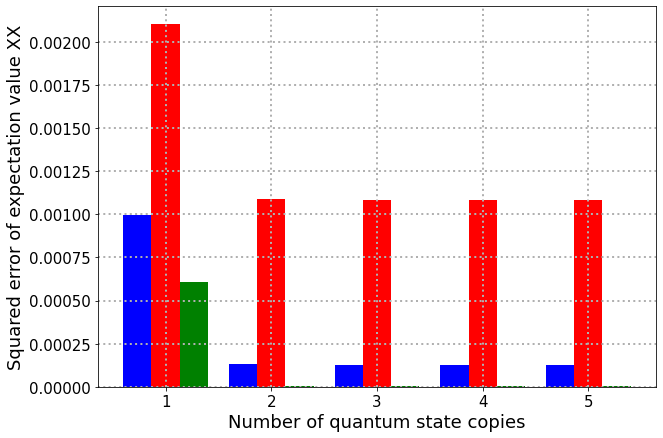

In [110]:
x = np.arange(1, 6)
tick_label = np.arange(1, 6).astype("str")
labels = ["depolarizing", "unitary", "depolarizing&unitary"]

mae_depolarizing_list = []
mae_unitary_list = []
mae_depolarizing_unitary_list = []

var_depolarizing_list = []
var_unitary_list = []
var_depolarizing_unitary_list = []

for col in ev_1000_sampiling_depolarizing_df.columns[::-1]:
    mae_depolarizing_list.append(np.square(1-np.mean(ev_1000000_sampiling_depolarizing_df[col].values)))
    mae_unitary_list.append(np.square(1-np.mean(ev_1000000_sampiling_unitary_df[col].values)))
    mae_depolarizing_unitary_list.append(np.square(1-np.mean(ev_1000000_sampiling_depolarizing_unitary_df[col].values)))
    
    var_depolarizing_list.append(np.var(ev_1000000_sampiling_depolarizing_df[col].values))
    var_unitary_list.append(np.var(ev_1000000_sampiling_unitary_df[col].values))
    var_depolarizing_unitary_list.append(np.var(ev_1000000_sampiling_depolarizing_unitary_df[col].values))

mae_data = [mae_depolarizing_list, mae_unitary_list, mae_depolarizing_unitary_list]
var_data = [var_depolarizing_list, var_unitary_list, var_depolarizing_unitary_list]

margin = 0.2
totoal_width = 1 - margin
color_list = ["blue", "red", "green"]
plt.figure(figsize=(10, 7))

for i, (h, label, c) in enumerate(zip(mae_data, labels, color_list)):
    pos = x - totoal_width *(1- (2*i+1)/len(mae_data) )/2
    plt.bar(pos, h, width = totoal_width/len(mae_data), label=label, tick_label=tick_label, align="center", color=c)

#plt.title('varying number of quantum state copy (error rate:1%)', fontsize=18)
plt.xlabel('Number of quantum state copies', fontsize=18)
plt.ylabel('Squared error of expectation value XX', fontsize=18)
plt.xticks(x, tick_label)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
#plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)
plt.savefig("./figures/varying_n_copy_bias_n_sample=1000000.pdf", bbox_inches='tight')

#### variance

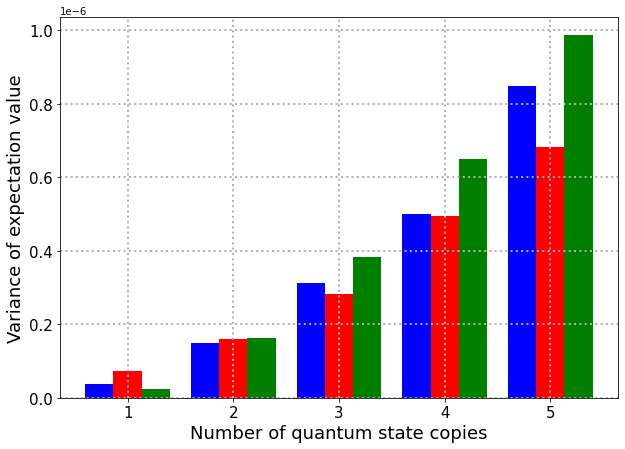

In [107]:
margin = 0.2
totoal_width = 1 - margin
color_list = ["blue", "red", "green"]
plt.figure(figsize=(10, 7))

for i, (h, label, c) in enumerate(zip(var_data, labels, color_list)):
    pos = x - totoal_width *( 1- (2*i+1)/len(var_data) )/2
    plt.bar(pos, h, width = totoal_width/len(var_data), label=label, tick_label=tick_label, align="center", color=c)

#plt.title('varying number of quantum state copy (error rate:1%)', fontsize=18)
plt.xlabel('Number of quantum state copies', fontsize=18)
plt.ylabel('Variance of expectation value', fontsize=18)
plt.xticks(x, tick_label)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
#plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=18)
plt.savefig("./figures/varying_n_copy_variance_n_sample=1000000.pdf", bbox_inches='tight')

## varying n_sample

### n_copy = 1

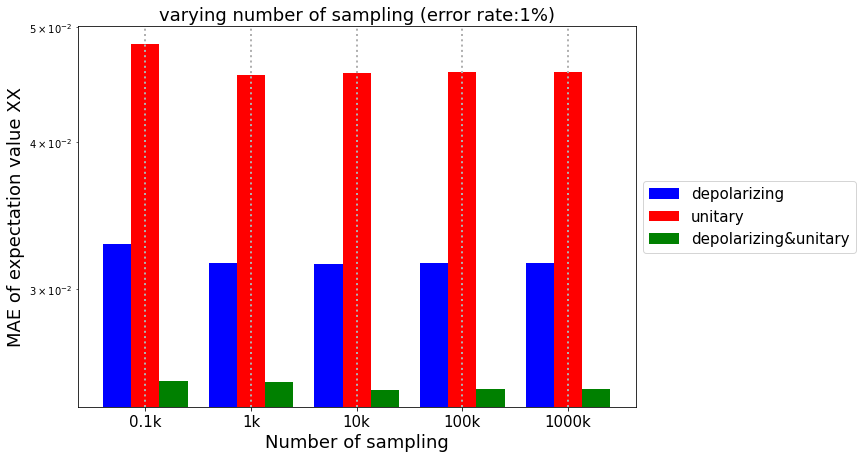

In [59]:
x = np.arange(1, 6)
tick_label = ["0.1k", "1k", "10k", "100k", "1000k"]
labels = ["depolarizing", "unitary", "depolarizing&unitary"]

mae_depolarizing_list = []
mae_unitary_list = []
mae_depolarizing_unitary_list = []

mae_depolarizing_list.append(np.mean(np.abs(1-ev_100_sampiling_depolarizing_df["n_copy=1"].values)))
mae_depolarizing_list.append(np.mean(np.abs(1-ev_1000_sampiling_depolarizing_df["n_copy=1"].values)))
mae_depolarizing_list.append(np.mean(np.abs(1-ev_10000_sampiling_depolarizing_df["n_copy=1"].values)))
mae_depolarizing_list.append(np.mean(np.abs(1-ev_100000_sampiling_depolarizing_df["n_copy=1"].values)))
mae_depolarizing_list.append(np.mean(np.abs(1-ev_1000000_sampiling_depolarizing_df["n_copy=1"].values)))

mae_unitary_list.append(np.mean(np.abs(1-ev_100_sampiling_unitary_df["n_copy=1"].values)))
mae_unitary_list.append(np.mean(np.abs(1-ev_1000_sampiling_unitary_df["n_copy=1"].values)))
mae_unitary_list.append(np.mean(np.abs(1-ev_10000_sampiling_unitary_df["n_copy=1"].values)))
mae_unitary_list.append(np.mean(np.abs(1-ev_100000_sampiling_unitary_df["n_copy=1"].values)))
mae_unitary_list.append(np.mean(np.abs(1-ev_1000000_sampiling_unitary_df["n_copy=1"].values)))

mae_depolarizing_unitary_list.append(np.mean(np.abs(1-ev_100_sampiling_depolarizing_unitary_df["n_copy=1"].values)))
mae_depolarizing_unitary_list.append(np.mean(np.abs(1-ev_1000_sampiling_depolarizing_unitary_df["n_copy=1"].values)))
mae_depolarizing_unitary_list.append(np.mean(np.abs(1-ev_10000_sampiling_depolarizing_unitary_df["n_copy=1"].values)))
mae_depolarizing_unitary_list.append(np.mean(np.abs(1-ev_100000_sampiling_depolarizing_unitary_df["n_copy=1"].values)))
mae_depolarizing_unitary_list.append(np.mean(np.abs(1-ev_1000000_sampiling_depolarizing_unitary_df["n_copy=1"].values)))

mae_data = [mae_depolarizing_list, mae_unitary_list, mae_depolarizing_unitary_list]

margin = 0.2
totoal_width = 1 - margin
color_list = ["blue", "red", "green"]
plt.figure(figsize=(10, 7))

for i, (h, label, c) in enumerate(zip(mae_data, labels, color_list)):
    pos = x - totoal_width *( 1- (2*i+1)/len(mae_data) )/2
    plt.bar(pos, h, width = totoal_width/len(mae_data), label=label, tick_label=tick_label, align="center", color=c)

plt.title('varying number of sampling (error rate:1%)', fontsize=18)
plt.xlabel('Number of sampling', fontsize=18)
plt.ylabel('MAE of expectation value XX', fontsize=18)
plt.yscale('log')
plt.xticks(x, tick_label)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)

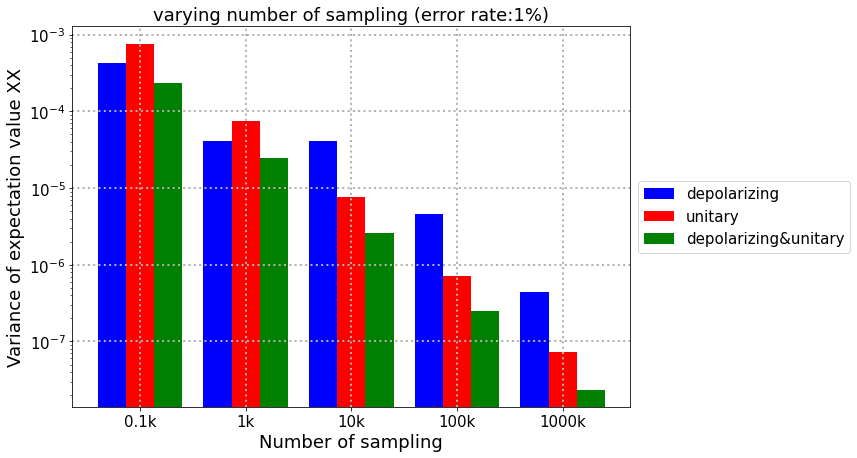

In [60]:
var_depolarizing_list = []
var_unitary_list = []
var_depolarizing_unitary_list = []

var_depolarizing_list.append(np.var(ev_100_sampiling_depolarizing_df["n_copy=1"].values))
var_depolarizing_list.append(np.var(ev_1000_sampiling_depolarizing_df["n_copy=1"].values))
var_depolarizing_list.append(np.var(ev_1000_sampiling_depolarizing_df["n_copy=1"].values))
var_depolarizing_list.append(np.var(ev_10000_sampiling_depolarizing_df["n_copy=1"].values))
var_depolarizing_list.append(np.var(ev_100000_sampiling_depolarizing_df["n_copy=1"].values))

var_unitary_list.append(np.var(ev_100_sampiling_unitary_df["n_copy=1"].values))
var_unitary_list.append(np.var(ev_1000_sampiling_unitary_df["n_copy=1"].values))
var_unitary_list.append(np.var(ev_10000_sampiling_unitary_df["n_copy=1"].values))
var_unitary_list.append(np.var(ev_100000_sampiling_unitary_df["n_copy=1"].values))
var_unitary_list.append(np.var(ev_1000000_sampiling_unitary_df["n_copy=1"].values))

var_depolarizing_unitary_list.append(np.var(ev_100_sampiling_depolarizing_unitary_df["n_copy=1"].values))
var_depolarizing_unitary_list.append(np.var(ev_1000_sampiling_depolarizing_unitary_df["n_copy=1"].values))
var_depolarizing_unitary_list.append(np.var(ev_10000_sampiling_depolarizing_unitary_df["n_copy=1"].values))
var_depolarizing_unitary_list.append(np.var(ev_100000_sampiling_depolarizing_unitary_df["n_copy=1"].values))
var_depolarizing_unitary_list.append(np.var(ev_1000000_sampiling_depolarizing_unitary_df["n_copy=1"].values))

var_data = [var_depolarizing_list, var_unitary_list, var_depolarizing_unitary_list]

margin = 0.2
totoal_width = 1 - margin
color_list = ["blue", "red", "green"]
plt.figure(figsize=(10, 7))

for i, (h, label, c) in enumerate(zip(var_data, labels, color_list)):
    pos = x - totoal_width *( 1- (2*i+1)/len(var_data) )/2
    plt.bar(pos, h, width = totoal_width/len(var_data), label=label, tick_label=tick_label, align="center", color=c)

plt.title('varying number of sampling (error rate:1%)', fontsize=18)
plt.xlabel('Number of sampling', fontsize=18)
plt.ylabel('Variance of expectation value XX', fontsize=18)
plt.yscale('log')
plt.xticks(x, tick_label)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)

### n_copy = 2

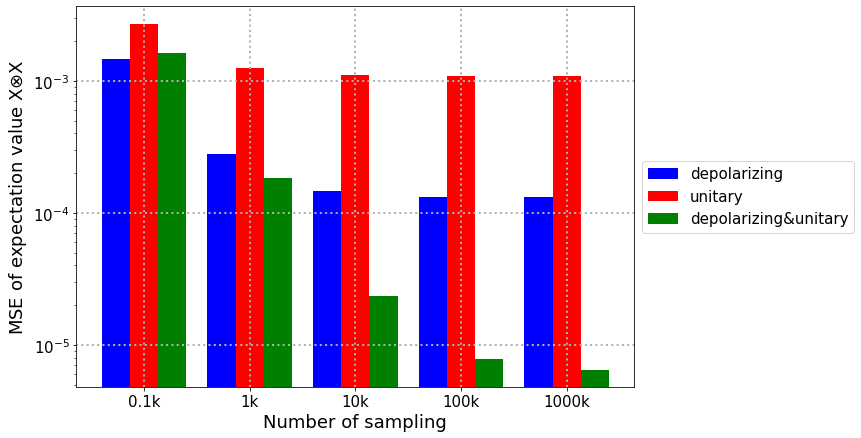

In [104]:
x = np.arange(1, 6)
tick_label = ["0.1k", "1k", "10k", "100k", "1000k"]
labels = ["depolarizing", "unitary", "depolarizing&unitary"]

mae_depolarizing_list = []
mae_unitary_list = []
mae_depolarizing_unitary_list = []

mae_depolarizing_list.append(np.mean(np.square(1-ev_100_sampiling_depolarizing_df["n_copy=2"].values)))
mae_depolarizing_list.append(np.mean(np.square(1-ev_1000_sampiling_depolarizing_df["n_copy=2"].values)))
mae_depolarizing_list.append(np.mean(np.square(1-ev_10000_sampiling_depolarizing_df["n_copy=2"].values)))
mae_depolarizing_list.append(np.mean(np.square(1-ev_100000_sampiling_depolarizing_df["n_copy=2"].values)))
mae_depolarizing_list.append(np.mean(np.square(1-ev_1000000_sampiling_depolarizing_df["n_copy=2"].values)))

mae_unitary_list.append(np.mean(np.square(1-ev_100_sampiling_unitary_df["n_copy=2"].values)))
mae_unitary_list.append(np.mean(np.square(1-ev_1000_sampiling_unitary_df["n_copy=2"].values)))
mae_unitary_list.append(np.mean(np.square(1-ev_10000_sampiling_unitary_df["n_copy=2"].values)))
mae_unitary_list.append(np.mean(np.square(1-ev_100000_sampiling_unitary_df["n_copy=2"].values)))
mae_unitary_list.append(np.mean(np.square(1-ev_1000000_sampiling_unitary_df["n_copy=2"].values)))

mae_depolarizing_unitary_list.append(np.mean(np.square(1-ev_100_sampiling_depolarizing_unitary_df["n_copy=2"].values)))
mae_depolarizing_unitary_list.append(np.mean(np.square(1-ev_1000_sampiling_depolarizing_unitary_df["n_copy=2"].values)))
mae_depolarizing_unitary_list.append(np.mean(np.square(1-ev_10000_sampiling_depolarizing_unitary_df["n_copy=2"].values)))
mae_depolarizing_unitary_list.append(np.mean(np.square(1-ev_100000_sampiling_depolarizing_unitary_df["n_copy=2"].values)))
mae_depolarizing_unitary_list.append(np.mean(np.square(1-ev_1000000_sampiling_depolarizing_unitary_df["n_copy=2"].values)))

mae_data = [mae_depolarizing_list, mae_unitary_list, mae_depolarizing_unitary_list]

margin = 0.2
totoal_width = 1 - margin
color_list = ["blue", "red", "green"]
plt.figure(figsize=(10, 7))

for i, (h, label, c) in enumerate(zip(mae_data, labels, color_list)):
    pos = x - totoal_width *( 1- (2*i+1)/len(mae_data) )/2
    plt.bar(pos, h, width = totoal_width/len(mae_data), label=label, tick_label=tick_label, align="center", color=c)

#plt.title('varying number of sampling (error rate:1%)', fontsize=18)
plt.xlabel('Number of sampling', fontsize=18)
plt.ylabel('MSE of expectation value X$\otimes$X', fontsize=18)
plt.yscale('log')
plt.xticks(x, tick_label)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)
plt.savefig("./figures/varying_n_sample_variance_n_copy=2.pdf", bbox_inches='tight')

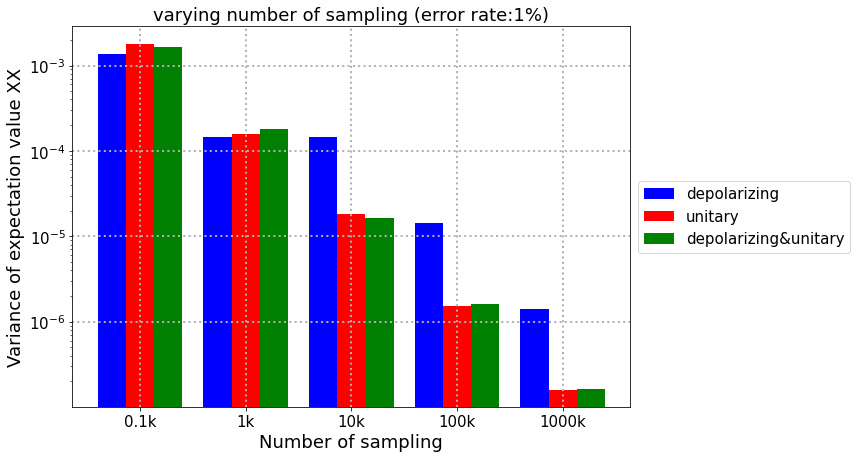

In [62]:
var_depolarizing_list = []
var_unitary_list = []
var_depolarizing_unitary_list = []

var_depolarizing_list.append(np.var(ev_100_sampiling_depolarizing_df["n_copy=2"].values))
var_depolarizing_list.append(np.var(ev_1000_sampiling_depolarizing_df["n_copy=2"].values))
var_depolarizing_list.append(np.var(ev_1000_sampiling_depolarizing_df["n_copy=2"].values))
var_depolarizing_list.append(np.var(ev_10000_sampiling_depolarizing_df["n_copy=2"].values))
var_depolarizing_list.append(np.var(ev_100000_sampiling_depolarizing_df["n_copy=2"].values))

var_unitary_list.append(np.var(ev_100_sampiling_unitary_df["n_copy=2"].values))
var_unitary_list.append(np.var(ev_1000_sampiling_unitary_df["n_copy=2"].values))
var_unitary_list.append(np.var(ev_10000_sampiling_unitary_df["n_copy=2"].values))
var_unitary_list.append(np.var(ev_100000_sampiling_unitary_df["n_copy=2"].values))
var_unitary_list.append(np.var(ev_1000000_sampiling_unitary_df["n_copy=2"].values))

var_depolarizing_unitary_list.append(np.var(ev_100_sampiling_depolarizing_unitary_df["n_copy=2"].values))
var_depolarizing_unitary_list.append(np.var(ev_1000_sampiling_depolarizing_unitary_df["n_copy=2"].values))
var_depolarizing_unitary_list.append(np.var(ev_10000_sampiling_depolarizing_unitary_df["n_copy=2"].values))
var_depolarizing_unitary_list.append(np.var(ev_100000_sampiling_depolarizing_unitary_df["n_copy=2"].values))
var_depolarizing_unitary_list.append(np.var(ev_1000000_sampiling_depolarizing_unitary_df["n_copy=2"].values))

var_data = [var_depolarizing_list, var_unitary_list, var_depolarizing_unitary_list]

margin = 0.2
totoal_width = 1 - margin
color_list = ["blue", "red", "green"]
plt.figure(figsize=(10, 7))

for i, (h, label, c) in enumerate(zip(var_data, labels, color_list)):
    pos = x - totoal_width *( 1- (2*i+1)/len(var_data) )/2
    plt.bar(pos, h, width = totoal_width/len(var_data), label=label, tick_label=tick_label, align="center", color=c)

plt.title('varying number of sampling (error rate:1%)', fontsize=18)
plt.xlabel('Number of sampling', fontsize=18)
plt.ylabel('Variance of expectation value XX', fontsize=18)
plt.yscale('log')
plt.xticks(x, tick_label)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)

## varying method

### depolarizing error

In [ ]:
mae_depolarizing_df = 